<a href="https://colab.research.google.com/github/gombergere/arthomas/blob/master/Autocar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
file = files.upload()

In [0]:
import cv2
import numpy as np

from sklearn.linear_model import HuberRegressor, Ridge


In [0]:
!pip install opencv-python
!pip install cvlib
import cv2
import matplotlib.pyplot as plt
import cvlib as cv


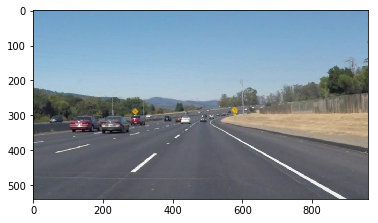

In [8]:
im=cv2.imread('solidwhiteline.jpg')
im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()

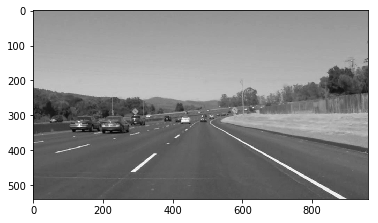

In [10]:
gray_img = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_img, cmap='gray')
plt.show()

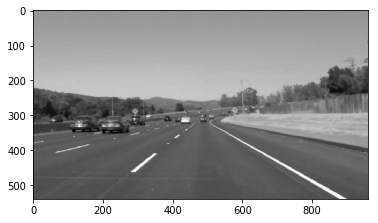

In [13]:
kernel_size = 5
gauss_img = cv2.GaussianBlur(gray_img,(kernel_size, kernel_size), 0)
plt.imshow(gauss_img, cmap='gray')
plt.show()

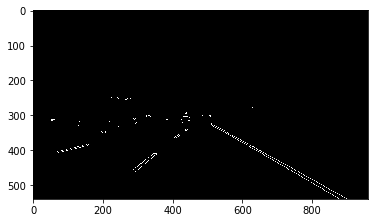

In [14]:
low_threshold, high_threshold = [200, 300]
canny_img = cv2.Canny(gauss_img, low_threshold, high_threshold)
plt.imshow(canny_img, cmap='gray')
plt.show()

In [0]:
import cv2
import numpy as np

from sklearn.linear_model import HuberRegressor, Ridge


class LineDetector:
    def __init__(self, **kargs):
        self.gaussian_kernel = kargs['gaussian_kernel']
        self.low_threshold, self.high_threshold = kargs['canny_thresholds']
        self.hough_settings = kargs['hough_settings']
        self.line_threshold = kargs['line_threshold']
        self.line_thickness = kargs['line_thickness']


    def grayscale(self, img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


    def canny(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)


    def gaussian_blur(self, img, kernel_size):
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


    def region_of_interest(self, img, vertices):
        mask = np.zeros_like(img)   
        if len(img.shape) > 2:
            channel_count = img.shape[2]
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        cv2.fillPoly(mask, vertices, ignore_mask_color)
        return cv2.bitwise_and(img, mask)


    def draw_lines(self, img, lines):
        line_dict = {'left':[], 'right':[]}
        img_center = img.shape[1]//2
        for line in lines:
            for x1, y1, x2, y2 in line:
                if x1<img_center and x2<img_center:
                    position = 'left'
                elif x1>img_center and x2>img_center:
                    position = 'right'
                else:
                    continue
                line_dict[position].append(np.array([x1, y1]))
                line_dict[position].append(np.array([x2, y2]))

        for position, lines_dir in line_dict.items():
            data = np.array(lines_dir)
            data = data[data[:, 1] >= np.array(self.line_threshold)-1]
            x, y = data[:, 0].reshape((-1, 1)), data[:, 1]

            try:
                model = HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100,
                                    epsilon=1.9)
                model.fit(x, y)
            except ValueError:
                model = Ridge(fit_intercept=True, alpha=0.0, random_state=0, normalize=True)
                model.fit(x, y)

            epsilon = 1e-10
            y1 = np.array(img.shape[0])
            x1 = (y1 - model.intercept_)/(model.coef_+epsilon)
            y2 = np.array(self.line_threshold)
            x2 = (y2 - model.intercept_)/(model.coef_+epsilon)
            x = np.append(x, [x1, x2], axis=0)

            y_pred = model.predict(x)
            data = np.append(x, y_pred.reshape((-1, 1)), axis=1)
            cv2.polylines(img, np.int32([data]), isClosed=False,
                          color=(255, 0, 0), thickness=self.line_thickness)


    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap):
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                                minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        self.draw_lines(line_img, lines)
        return line_img


    def weighted_img(self, img, initial_img, α=0.95, β=1., γ=0.):
        return cv2.addWeighted(initial_img, α, img, β, γ)


    def forward(self, img):
        """Detect lines and draw them on the image"""
        img_line = self.grayscale(img)
        img_line = self.gaussian_blur(img_line, kernel_size=self.gaussian_kernel)
        img_line = self.canny(img_line, low_threshold=self.low_threshold,
                              high_threshold=self.high_threshold)
        vertices = np.array([[(0, img_line.shape[0]), (img_line.shape[1], img_line.shape[0]),
                              (400, 260), (600, 260)]])
        img_line = self.region_of_interest(img_line, vertices)
        img_line = self.hough_lines(img_line, **self.hough_settings)
        return self.weighted_img(img_line, img)



In [31]:
# make a blank/white image
#mask = np.zeros_like(img)
#"mask_channels = (255,) * img.shape[2]
# Fill the area of interest with 0 and 255 these
# which lie outside of it, thoughout all color channels
cv2.fillPoly(mask, vertices, mask_channels)
# Keep only the pixels with 0 value of the canny_img
masked_img = cv2.bitwise_and(canny_img, mask)
plt.imshow(masked_img, cmap='gray')
plt.show()

NameError: ignored